In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import glob
import time
from tqdm import tqdm
import os
import json
from lvm_prediction import predict
import pingouin as pg

## Initial calculations

In [3]:
def calc_taylor_slope(data):
    # Placeholder for actual slope calculation logic
    # Assuming data to be a 2D array-like structure
    means = data.mean(axis=0)
    variances = data.var(axis=0)
    slope = np.polyfit(np.log(means), np.log(variances), 1)[0]
    return slope

def calc_alpha(data):
    return sp.stats.entropy(data, axis=1).mean()

def fit_exp(data):
    data = data[:5]
    data = data/data[0]
    model = LinearRegression()
    try:
        model.fit(np.arange(len(data)).reshape(-1, 1), np.log(data))
    except:
        return np.nan
    exponent = -model.coef_[0]
    return exponent

def participation_ratio(eigenvalues):
    return (np.sum(eigenvalues) ** 2) / np.sum(eigenvalues ** 2)

def get_shuffled(data, normalization=True):
    permuted_data = np.array([np.random.permutation(x) for x in data.T]).T
    if normalization:
        permuted_data /= np.sum(permuted_data, axis=1)[:, np.newaxis]
    return permuted_data

def calc_env_dim(met):
    met[met<=0] = 0.1*np.min(met[met>0])
    log_met = np.log(met) 
    
    met = met - np.mean(met, axis=0)[np.newaxis, :]
    met = met[:, ~(np.std(met, axis=0)==0)]
    met_std = np.std(met, axis=0)
    assert np.all(met_std!=0), "Met is not filtered properly"
       
    log_met = log_met - np.mean(log_met, axis=0)[np.newaxis, :]
    log_met = log_met[:, ~(np.std(log_met, axis=0)==0)]
    log_met_std = np.std(log_met, axis=0)
    assert np.all(log_met_std!=0), "Log-Met is not filtered properly"
    
    met = met/met_std[np.newaxis, :]
    log_met = log_met/log_met_std[np.newaxis, :]
    
    met_shuffled = get_shuffled(met, normalization=False)
    log_met_shuffled = get_shuffled(log_met, normalization=False)
    
    svd = np.linalg.svd(met, compute_uv=False, full_matrices=False)
    svd_log = np.linalg.svd(log_met, compute_uv=False, full_matrices=False)
    svd_shuffled = np.linalg.svd(met_shuffled, compute_uv=False, full_matrices=False)
    svd_shuffled_log = np.linalg.svd(log_met_shuffled, compute_uv=False, full_matrices=False)
    
    
    env_dim = 1/fit_exp(svd)
    env_dim_log = 1/fit_exp(svd_log)
    env_pr = participation_ratio(svd)
    env_pr_log = participation_ratio(svd_log)
    env_shuffled_pr = participation_ratio(svd_shuffled)
    env_shuffled_pr_log = participation_ratio(svd_shuffled_log)
    env_pr_corrected = env_pr - env_shuffled_pr
    env_pr_log_corrected = env_pr_log - env_shuffled_pr_log
    
    return env_dim, env_dim_log, env_pr, env_pr_log, env_pr_corrected, env_pr_log_corrected

def calc_generalists(crm, mean_abu):
    # sparsity = np.sum(crm)/crm.size    
    # mean_num_resources = crm.shape[1]*sparsity
    # weighted_num_resources = np.dot(crm.sum(axis=1), mean_abu)
    # weighted_to_mean_ratio = weighted_num_resources/mean_num_resources
    
    # return weighted_to_mean_ratio
    return np.dot(mean_abu, crm.sum(axis=1))/np.mean(crm.sum(axis=1))  

In [ ]:
files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v6/*.json')
num_processed = 0
for file in files:
    num_niches = int(file.split('_')[-1].split('.')[0])
    print("Num niches:", num_niches)

    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)
    
    best_dist_list = []    
    for dataset in data_list:
        # print(dataset.keys())
        project_id = dataset['label']

        best_dist = dataset['best_dist']
        best_dist_list.append(best_dist)
    best_dist_list = np.array(best_dist_list)
    num_processed += best_dist_list.size
    print(f'Max: {np.max(best_dist_list):.2f}, Mean: {np.mean(best_dist_list):.2f}, Min: {np.min(best_dist_list):.2f}, Percent under 0.3: {(np.sum(best_dist_list<0.3)/best_dist_list.size):.2f}, No. of projects: {best_dist_list.size}\n')
        

In [4]:
in_silico_checkpoint_file = '/home/ks2823/Microbiomap/checkpoints/in_silico_v6.csv'
files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v6/*.json')

in_silico_df = pd.DataFrame() 

# try:
#     in_silico_df = pd.read_csv(in_silico_checkpoint_file, index_col=0)
# except FileNotFoundError:
#     print(f"Checkpoint file not found: {in_silico_checkpoint_file}. Starting with an empty DataFrame.")
# except Exception as e:
#     print(f"An error occurred while reading the checkpoint file: {e}")

for file in files:
    
    num_niches = int(file.split('_')[-1].split('.')[0])
    print("Num niches:", num_niches)

    processed_projects = []
    if not in_silico_df.empty:
        processed_projects = list(in_silico_df[in_silico_df['num_niches'] == num_niches]['label'])
        print(f'Already processed {len(processed_projects)}')

    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)

    for dataset in tqdm(data_list):
        # print(dataset.keys())
        if dataset['best_dist'] > 0.3:
            continue
        project_id = dataset['label']
        
        if project_id in processed_projects:
            # print(f'Skipping {project_id}')
            continue

        abu = np.array(dataset['data'])
        metadata = np.array(dataset['metadata'])
        
        inflow = np.array(dataset['inflow'])
        total_abu = np.sum(abu, axis=1)
        rel_abu = abu/total_abu[:, np.newaxis]
        
        load_ratio = total_abu.mean()/inflow.mean()

        mult_data = np.array([np.random.multinomial(10000, sample) for sample in rel_abu])
        rel_mult_data = mult_data/np.sum(mult_data, axis=1)[:, np.newaxis]

        mult_survival_idxs = np.mean(rel_mult_data, axis=0) >= 1e-3

        preference_list = np.array(dataset['CRM'])[mult_survival_idxs, :]
        cosine_similarity = sp.spatial.distance.pdist(preference_list, 'cosine')
        preference_list[preference_list > 0] = 1

        data = rel_mult_data[:, mult_survival_idxs]
        data /= np.sum(data, axis=1)[:, np.newaxis]
        
        crm = np.array(dataset['CRM'])[mult_survival_idxs, :]
        non_zero_idxs = np.sum(crm, axis=0) > 0
        
        num_resources = non_zero_idxs.size
        
        crm = crm[:, non_zero_idxs]
        crm[crm>0] = 1
        
        crm_sparsity = np.mean(crm)
        mean_num_resources = np.mean(np.sum(crm, axis=1))
        
        taylor = calc_taylor_slope(data)
        alpha = calc_alpha(data)
        env_dim, env_dim_log, env_pr, env_pr_log, env_pr_corrected, env_pr_log_correced = calc_env_dim(inflow)
        
        generalists = calc_generalists(crm, data.mean(axis=0))

        output = {
            'label': project_id,
            'num_niches': num_niches,
            'mean_load' : total_abu.mean(),
            'var_load' : np.var(total_abu),
            'load_ratio': load_ratio,
            'mean_resources' : preference_list.sum(axis=1).mean(),
            'weighted_pref' : np.dot(data.mean(axis=0), preference_list.sum(axis=1)),
            'cosine_similarity': cosine_similarity.mean(),
            'taylor': taylor,
            'alpha': alpha,
            'EnvDim': env_dim,
            'EnvDimLog': env_dim_log,
            'EnvPr': env_pr,
            'EnvPrLog': env_pr_log, 
            'EnvPrCorr': env_pr_corrected,
            'EnvPrLogCorr': env_pr_log_correced,
            'best_dist': dataset['best_dist'],
            'num_resources': num_resources,
            'generalists': generalists,
            'crm_sparsity': crm_sparsity,
            'mean_num_resources': mean_num_resources,
        }
        
        in_silico_df = pd.concat([in_silico_df, pd.DataFrame([output])], ignore_index=True)
        in_silico_df.to_csv(in_silico_checkpoint_file)

Num niches: 1


100%|██████████| 50/50 [00:02<00:00, 20.38it/s]


Num niches: 10
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 21.16it/s]


Num niches: 2
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 22.14it/s]


Num niches: 3
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 18.75it/s]


Num niches: 4
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 23.98it/s]


Num niches: 5
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 19.89it/s]


Num niches: 6
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 19.31it/s]


Num niches: 7
Already processed 0


100%|██████████| 50/50 [00:02<00:00, 17.90it/s]


Num niches: 8
Already processed 0


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


Num niches: 9
Already processed 0


100%|██████████| 50/50 [00:03<00:00, 15.02it/s]


In [5]:
df_list = []

for i in tqdm(range(1, 11)):
    # Read the JSON files
    df_cg_i = pd.read_json(f'Data/in_silico_v6_results/in_silico_cg/cg_{i}.json', lines=True)
    df_cg_null_i = pd.read_json(f'Data/in_silico_v6_results/in_silico_cg_null/cg_null_{i}.json', lines=True)
    df_comp_i = pd.read_json(f'Data/in_silico_v6_results/in_silico_comp/comp_{i}.json', lines=True)
    # df_bin_pred_i = pd.read_json(f'Data/in_silico_v4_results/in_silico_bin_pred/in_silico_bin_pred_{i}.json', lines=True)
    # df_cv = pd.read_json(f'Data/in_silico_v4_results/in_silico_cv_theta/cv_theta_{i}.json', lines=True)
    # df_cv = df_cv.drop(columns=['NumNiches'])
    df_final_i = pd.merge(df_comp_i, df_cg_i, on='label')
    df_final_i = pd.merge(df_final_i, df_cg_null_i, on='label')
    # df_final_i = pd.merge(df_final_i, df_bin_pred_i, on='label')
    # df_final_i = pd.merge(df_final_i, df_cv, on='label')
    
    df_final_i['num_niches'] = i
    
    df_list.append(df_final_i)

100%|██████████| 10/10 [00:00<00:00, 58.09it/s]


In [6]:
df = pd.concat(df_list)
df['NicheDim'] = 1/df['exp_cg']
df['NicheDim_null'] = 1/df['exp_cg_null']
df['comp'] = df['comp'].apply(lambda x: np.sum(x))
df.head()

,label,comp,exp_cg,exp_cg_null,num_niches,NicheDim,NicheDim_null
0,PRJNA430990,8.002191,0.637747,0.177055,1,1.568020,5.647956
1,PRJEB27564,5.599240,0.049406,0.046418,1,20.240528,21.543467
2,PRJEB36316,5.657240,0.046435,0.043764,1,21.535406,22.850045
3,PRJNA625750,7.062013,0.157427,0.151768,1,6.352161,6.589005
4,PRJNA530790,6.546506,0.069573,0.068862,1,14.373361,14.521808


In [6]:
x = 1/df.dropna()['exp_cg']
y = df.dropna()['comp']

spearman, pval = sp.stats.spearmanr(x, y)
print(spearman, pval)

-0.22752321409285634 2.7119736267321375e-07


In [7]:
in_silico_df = pd.merge(in_silico_df, df, on=['num_niches', 'label'], how='inner')
print(len(in_silico_df))

429


In [8]:
in_silico_df.to_csv(in_silico_checkpoint_file)

## Load from checkpoint

In [8]:
in_silico_checkpoint_file = '/home/ks2823/Microbiomap/checkpoints/in_silico_v6.csv'
in_silico_df = pd.read_csv(in_silico_checkpoint_file, index_col=0)
in_silico_df['scaled_weighted_pref'] = in_silico_df['weighted_pref']/(in_silico_df['mean_resources'])
print(in_silico_df.head())
print(len(in_silico_df))

         label  num_niches  mean_load  var_load  load_ratio  mean_resources  \
0  PRJNA430990           1   0.024853  0.001310    0.009613       23.623188   
1   PRJEB27564           1  26.323161  1.764532   11.273306       23.355556   
2   PRJEB36316           1   3.673986  0.025742    1.535613       23.265306   
3  PRJNA625750           1   5.805701  1.960619    2.236119       23.421053   
4  PRJNA491657           1   0.916427  0.206043    0.364560       22.114286   

   weighted_pref  cosine_similarity    taylor     alpha  ...  EnvPrCorr  \
0      20.981103           0.917974  2.546947  1.948708  ...   0.022860   
1      23.071113           0.924668  0.913144  3.618372  ...  -0.164223   
2      23.179575           0.925200  0.843581  3.675291  ...   0.057652   
3      22.579310           0.921347  1.126919  2.012526  ...  -0.082521   
4      20.692709           0.921440  1.221668  1.465209  ...  -0.070949   

   EnvPrLogCorr  best_dist  num_resources  generalists  crm_sparsity  \
0 

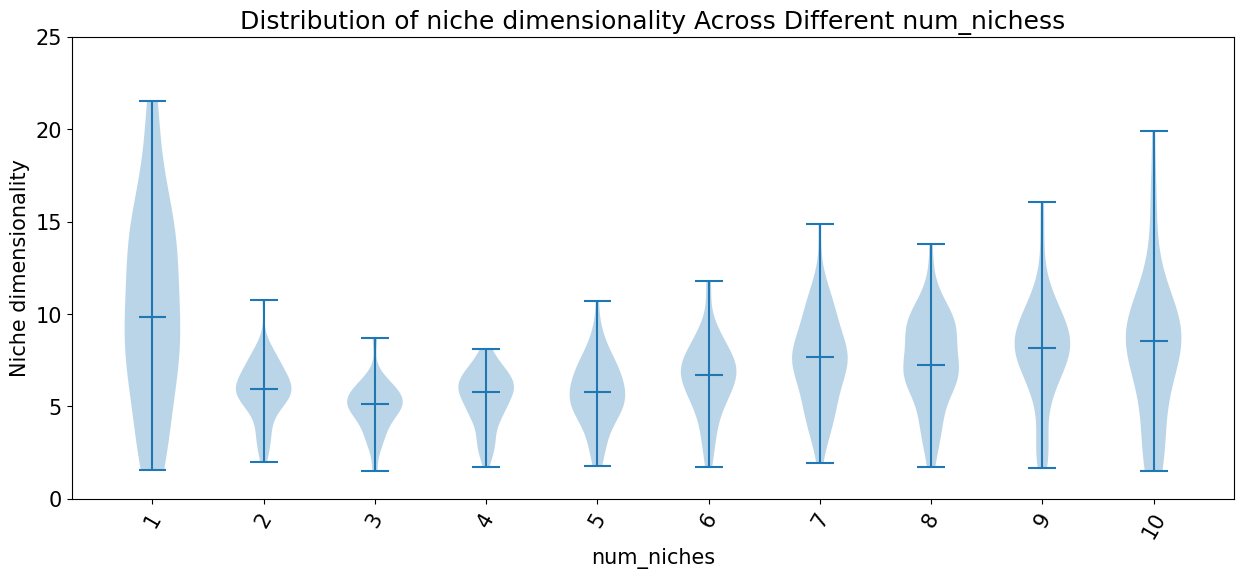

In [13]:
# Group exp_cg values by unique num_nichess
num_nichess = np.arange(1,11,1)
data = [in_silico_df[in_silico_df['num_niches'] == num_niches]['NicheDim'].values for num_niches in num_nichess]

# Create the violin plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data, positions=np.arange(len(num_nichess)), showmedians=True, showextrema=True)

# Customize the plot
ax.set_xticks(np.arange(len(num_nichess)))
ax.set_xticklabels(num_nichess, rotation=60)  # Rotate labels for better readability
ax.set_xlabel("num_niches")
ax.set_ylabel("Niche dimensionality")
ax.set_title("Distribution of niche dimensionality Across Different num_nichess")
plt.ylim([0, 25])
plt.show()

In [6]:
def plot_helper(x, y, c=None, x_label=None, y_label=None, title=None):
    plt.rcParams.update({'font.size': 20})
    
    spearman, pval = sp.stats.spearmanr(x, y)
    print(f'Spearman R: {spearman}, P-value: {pval}')

    # Fit a straight line
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)

    # Create the line data
    line_x = np.linspace(min(x), max(x), 100)
    line_y = slope * line_x + intercept

    # Plot the line
    plt.figure(figsize=(7, 6))
    plt.plot(line_x, line_y, color='red', label=f'R: {spearman:.2f}', linestyle='--')

    if c is None:
        plt.scatter(x, y, color='black')
    else:
        plt.scatter(x, y, c=c)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [10]:
col_label_dict = {
    ### Dimensionality metrics
    # 'pr_corrected': 'Participation Ratio (corrected)',
    'NicheDim': 'Niche Dimensionality',
    # 'EnvDim': 'Environmental Dimensionality',
    # 'se_corrected': 'Spectrum Entropy (corrected)',
    # 'EnvDimLog': 'Environmental Dimensionality (Log)',
    
    ### Diversity metrics    
    # 'alpha': 'Shannon Entropy',
    # 'beta': 'Jensen-Shannon Divergence',
    
    ### Niche overlap metrics
    # 'theta_comp': 'Theta overlap',
    # 'theta_comp_corrected':'Theta overlap (corrected)',
    'comp': 'Niche Overlap',
    
    ### Generalists metrics
    
    # 'theta_generalists_pr': 'Theta Generalists PR',
    # 'theta_generalists_corrected': 'Theta Generalists (corrected)',
    'scaled_weighted_pref': 'Generalist ratio',
    
    ### Predictability metrics
    
    # 'binary_in_performance': 'Self predictability (in-sample)',
    # 'binary_out_performance': 'Self predictability (out-sample)',
    
    ### Others
    'mean_load': 'Load (mean)',
    # 'var_load': 'Load (variance)',
    # 'taylor': 'Taylor\'s Slope',
    # 'load_ratio': 'Normalized Load',
    # 'num_resources': 'No. of resources',
    }

Spearman R: -0.38293707342683575, P-value: 2.188527158925767e-08


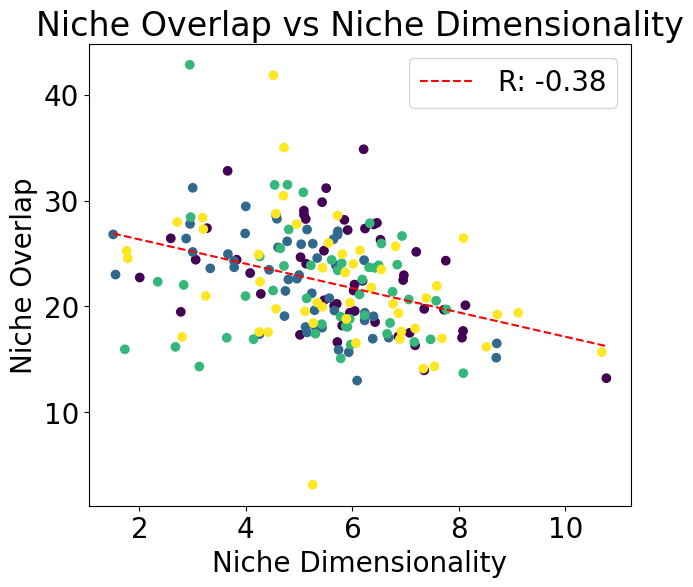

Spearman R: 0.012973824345608643, P-value: 0.8553196675437017


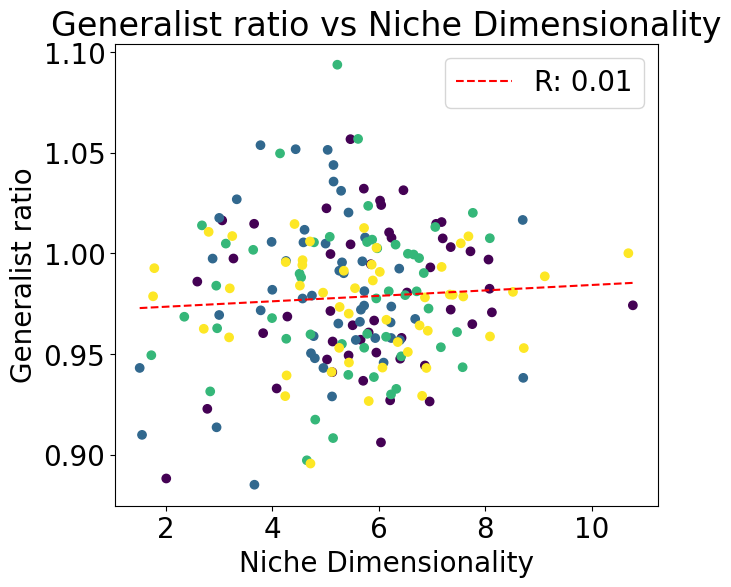

Spearman R: 0.35854496362409066, P-value: 1.8562931104684502e-07


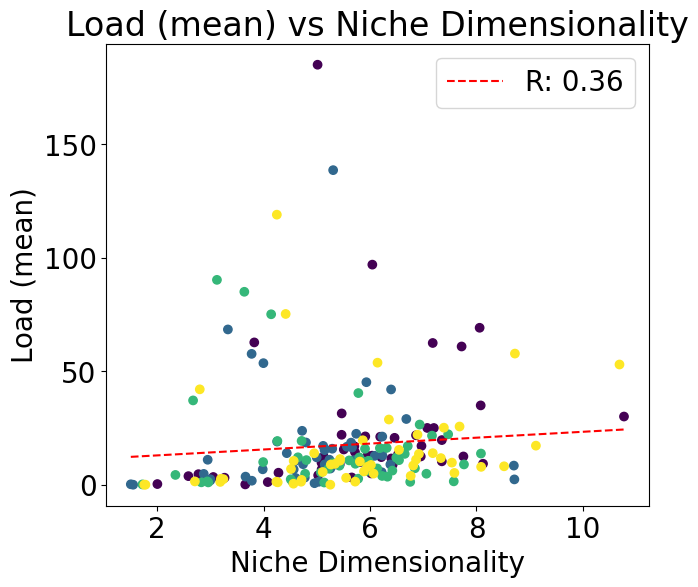

In [12]:
from itertools import combinations

# assuming combined_df and col_label_dict are already defined, and plot_helper is in scope

for x_col, y_col in combinations(col_label_dict.keys(), 2):
    if x_col != 'NicheDim':
        continue
    
    x = in_silico_df[x_col]
    y = in_silico_df[y_col]
    c = in_silico_df['num_niches']
    
    mask = (c > 1) & (c < 6)
    
    x = x[mask]
    y = y[mask]
    c = c[mask]
    
    x_label = col_label_dict[x_col]
    y_label = col_label_dict[y_col]
    title   = f"{y_label} vs {x_label}"
    
    plot_helper(
        x, y,c=c,
        x_label=x_label,
        y_label=y_label,
        title=title
    )
    # plt.savefig(f'/home/ks2823/Microbiomap/Data/in_silico_v6_results/plots/IS_{x_col}_{y_col}.pdf', format='pdf')